In [136]:
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import pandas as pd
import time
import pickle
import shutil
import argparse
import numpy as np
import glob
import torch.nn as nn
import torch
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

import os
import time
import pickle

import shutil
import argparse
import numpy as np

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets.folder import ImageFolder

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (index,) + (path,))
        return tuple_with_path

def get_train_valid_test_loader(args, random_seed, augment = False, valid_size=0.2, test_size=0.1, shuffle=True):
    """
    show_sample=False
    pin_memory=False
    num_workers=4
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.5394, 0.5394, 0.5394],
        std=[0.2447, 0.2447, 0.2447],
    )

    # define transforms
    valid_transform = transforms.Compose([
                      transforms.Resize([256,256]),
                      transforms.ToTensor(),
                      normalize,
                                        ])
    test_transform  = transforms.Compose([
                      transforms.Resize([256,256]),
                      transforms.ToTensor(),
                      normalize,
                                        ])
    if augment:
        train_transform = transforms.Compose([
                      transforms.Resize([256,256]),
                      transforms.RandomCrop(32, padding=4),
                      transforms.RandomHorizontalFlip(),
                      transforms.ToTensor(),
                      normalize,
        ])
    else:
        train_transform = transforms.Compose([
                          transforms.Resize([256,256]),
                          transforms.ToTensor(),
                          normalize,
        ])

    # load the dataset with the whole data
    train_dataset_transform = ImageFolderWithPaths(root=args.data_path, transform=train_transform)
    valid_dataset_transform = ImageFolderWithPaths(root=args.data_path, transform=valid_transform)
    test_dataset_transform  = ImageFolderWithPaths(root=args.data_path, transform=test_transform)

    num_train = len(train_dataset_transform)
    indices = list(range(num_train))
    split_valid = int(np.floor(valid_size * num_train))
    split_test = int(np.floor(test_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx, test_idx = indices[(split_valid+split_test):], indices[split_test:(split_valid+split_test)], indices[:split_test]

    train_dataset = torch.utils.data.Subset(train_dataset_transform, train_idx)
    valid_dataset = torch.utils.data.Subset(valid_dataset_transform, valid_idx)
    test_dataset  = torch.utils.data.Subset(test_dataset_transform , test_idx)
    
    return (train_dataset, valid_dataset, test_dataset)

In [137]:
class argss:
    def __init__(self, data_path, batch_size):       
        self.data_path = data_path
        self.batch_size = batch_size
args = argss("./breast", 
            16)

In [138]:
batch_size = 1
train_dataset, valid_dataset, test_dataset = get_train_valid_test_loader(args,
                                                                            50,
                                                                            False,
                                                                            0.2,
                                                                            0.1,
                                                                            True
                                                                            )
val_loader  = DataLoader(valid_dataset, batch_size=batch_size, shuffle = False)
device = "cuda" if torch.cuda.is_available() else "cpu"
#modelPath = './probsThresthold_0.89_batch_size_16_batchNumber_1_epochs_3000_ver_0_model'
#modelPath = './probsThresthold_0.40_batch_size_16_batchNumber_1_epochs_1000_weightIncrement_100.00_ver_0_model'
#modelPath = './best_model_state'
#modelPath = "./model_2998"
modelPath = "probsThresthold_0.97_batch_size_16_batchNumber_1_epochs_4000_ver_0_model"

In [139]:
modelNoWeight = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
modelNoWeight.fc = nn.Sequential(nn.Linear(modelNoWeight.fc.in_features,500), nn.ReLU(), nn.Dropout(), nn.Linear(500,3))
model_temp = torch.load(modelPath)
#name = 'best_model_state'
name = 'best_model'
#name = "model_2998"
modelNoWeight.to(device)
modelNoWeight.load_state_dict(model_temp[name])

Using cache found in /home/huong_n_pham01/.cache/torch/hub/pytorch_vision_v0.9.0


<All keys matched successfully>

In [ ]:
modelNoWeight.eval()

num_correct = 0
num_examples = 0
match = []
targetList = []
predList   = []
probList   = []
pathList   = []

for index, data in enumerate(val_loader):
    input, target, id, path = data
    input = input.to(device)
    output = modelNoWeight(input)
    target = target.to(device)
    pred   = torch.max(F.softmax(output, dim = 1), dim=1)[1]
    prob = (torch.max(F.softmax(output, dim = 1), dim=1)[0])
    print("%s | %s | %s | %0.2f | %s | %s"%(((target == pred).item(), target.item(), pred.item(), prob.item(), path[0], id.item())))
    correct = torch.eq(torch.max(F.softmax(output, dim = 1), dim=1)[1],
    target).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
    match.append((target == pred).item())
    targetList.append(target.item())
    predList.append(pred.item())
    probList.append(prob.item())
    pathList.append(path[0])
print("Validation accuracy: {}".format(num_correct/num_examples))

In [140]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = modelNoWeight
target_layers = [model.layer4[-1]]

In [164]:
input_tensor, target, id, path = iter(val_loader).next()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


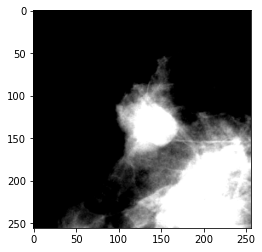

In [162]:
# CHOOSE THIS ONE
input_tensor[0].shape
image = input_tensor[0].permute(1, 2, 0).numpy()
plt.imshow(image)

rgb_img = cv2.imread(path[0], 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (256,256), interpolation = cv2.INTER_AREA)
rgb_img = np.float32(rgb_img) / 255

In [165]:
# SKIP
rgb_img = cv2.imread(path[0], 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (256,256), interpolation = cv2.INTER_AREA)
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.5394, 0.5394, 0.5394],
                                std=[0.2447, 0.2447, 0.2447])

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

In [166]:
#input_tensor = 
# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor,targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
visualization = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)
cv2.imwrite('new.jpg', visualization)

True

In [ ]:
model

In [ ]:
df = pd.DataFrame({"Match": match, "Target": targetList, "Prediction": predList, "Certainty": probList, "Path": pathList})
df.to_csv("test_best_model_state_0VS12.csv")

In [ ]:
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML

pd.set_option('display.max_colwidth', None)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((256, 256), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [ ]:
df['Images'] = df.Path.map(lambda f: get_thumbnail(f))

In [ ]:
HTML(df[['Match', 'Target', 'Prediction', 'Certainty', 'Images', 'Path']].to_html(formatters={'Images': image_formatter}, escape=False))

In [ ]:

df[['Match', 'Target', 'Prediction', 'Certainty', 'Images', 'Path']].to_html('IDRID_DME_model200_val.html',formatters={'Images': image_formatter}, escape=False)

In [ ]:
from pyLib.stopInstance import stop_instance
stop_instance('inlaid-fuze-338203','us-central1-a','pytorch-gpu')

In [ ]:
[0] * 100